In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset, Subset
# from torch.utils.data import sampler


import torchvision.datasets as dset
import torchvision.transforms as T

from PIL import Image

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing
# auto-reload functions before each instance running them
%load_ext autoreload
%autoreload 2

In [ ]:
# Remote instance set-up cell
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [ ]:
# directory setup cell
repo = 'tree-finder/'
location = 'google'
save_files = False

# Local paths
local_root = '/Users/etriesch/dev/'
colab_root = '/content/drive/My Drive/git/'
aws_root = '/home/ec2-user/'

# define root
if location == 'local':
  root = local_root
elif location == 'google':
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  root = colab_root
elif location == 'aws':
  root = aws_root

repo_path = root + repo
model_path = repo_path + 'models/'
data_path = repo_path + 'data/'
results_path = repo_path + 'results/'
sys.path.append(repo_path)

Mounted at /content/drive


In [ ]:
# setup cell
from notebooks.viz_fns import show_image_batch, set_plt_settings
from notebooks.data_processing import define_transforms, make_dataloaders, get_tree_class_likelihood, IMAGE_DIM, MEAN, STD
from notebooks.models import ResnetTransferClassifier
from notebooks.scrape_fns import get_filelist

set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [ ]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD, mirror=True, randomcrop=[10,25,50])
# create dataset by concatenating all transformations
treeds = []
for t in transforms:
    df = dset.ImageFolder(root=data_path + 'images_spec', transform=transforms[t])
    treeds.append(df)

treeds = ConcatDataset(treeds)
class_names = treeds.datasets[0].classes

In [ ]:
# make whole-dataset loader and sample loader
loader_all = DataLoader(dataset=treeds, batch_size=32, shuffle=False)

random_idxs = np.random.choice(range(len(treeds)), 200).tolist()
loader_samp = DataLoader(dataset=Subset(treeds, random_idxs), batch_size=6, shuffle=True)

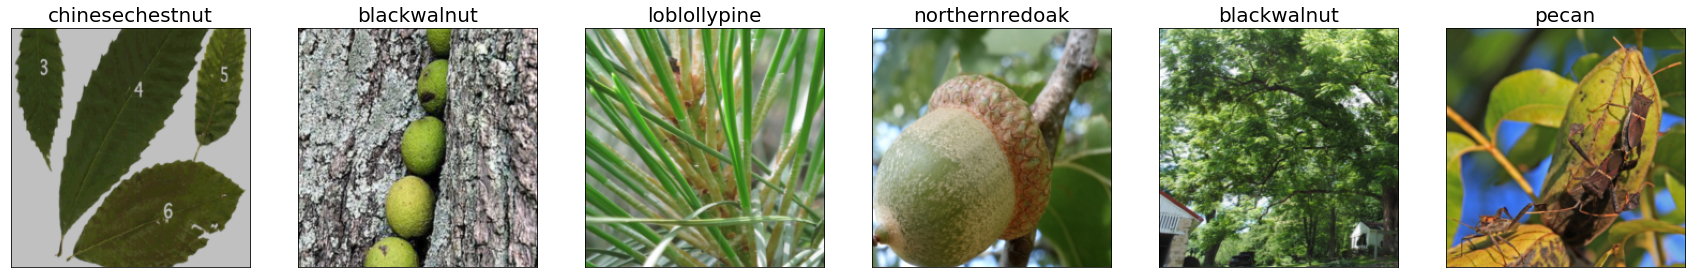

In [ ]:
# visualize images
samp_imgs, samp_classes = next(iter(loader_samp))
samp_imgs, samp_classes = samp_imgs.to(device), samp_classes.to(device)

# print(type(imgs), type(labels))
show_image_batch(samp_imgs.cpu(), MEAN, STD, title=[class_names[x] for x in samp_classes])

# Generate indices to subset dataset, based on binary tree classifier

In [ ]:
# load binary classifier
model = ResnetTransferClassifier(num_classes=2, retrain_last_cnblock=False)
model.load_state_dict(torch.load(model_path + 'ResnetBinClassifier.pt', map_location=torch.device('cpu')))
model.to(device)
model.eval()
print('success!')

success!


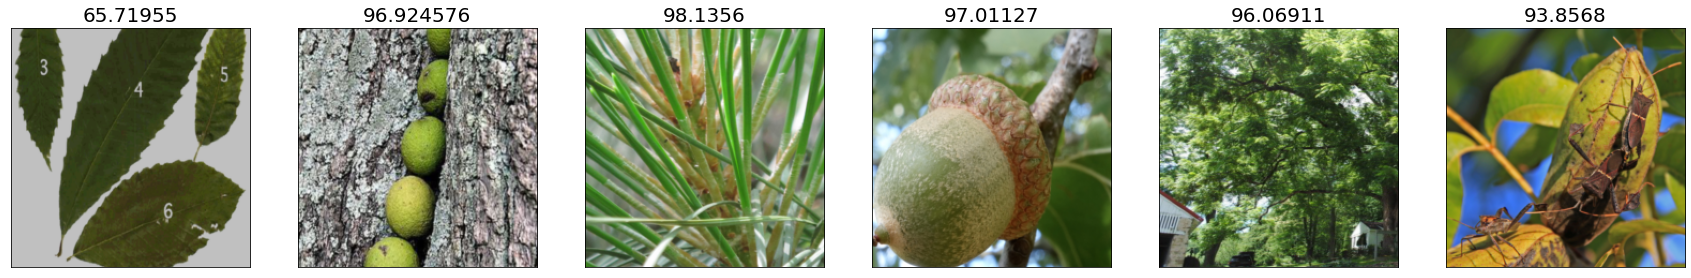

In [ ]:
# print scores for sample of images
scores = model(samp_imgs)
percentage = F.softmax(scores, dim=1) * 100
# print trees and score for detecting tree for a random sample of images
tree_likelihood = percentage[:,1].cpu().detach().numpy()
show_image_batch(samp_imgs.cpu(), MEAN, STD, title=tree_likelihood)

In [ ]:
# get indices for subsetting based on model classification
realtree_likelihood = get_tree_class_likelihood(classifier=model, loader=loader_all, device=device)

  4%|███▏                                                                       | 44/1026 [01:14<23:23,  1.43s/it]/opt/conda/envs/pytorch/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████| 1026/1026 [5:32:13<00:00, 19.43s/it]


In [ ]:
# save to file
if save_files:
  filename = 'images_spec_realtree_pcts.csv'
  np.savetxt(data_path + filename, np.array(realtree_likelihood), delimiter=",", fmt='%1.4f')

[autoreload of notebooks.data_processing failed: Traceback (most recent call last):
  File "/home/ec2-user/.local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/ec2-user/.local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/opt/conda/envs/pytorch/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/ec2-user/tree-finder/notebooks/data_processing.py", line 38
    transforms[f'crop{pct}_mirr'] = T.Compose([T.Resiz

In [ ]:
threshold=0.85
flag = np.array(realtree_likelihood) > threshold
realtree_idxs = (np.arange(0, len(flag))[flag]).tolist()
print(f'\nimages meeting {threshold:0.2%} threshold: {sum(flag)} ({sum(flag)/len(flag):0.2%})')


images meeting 85.00% threshold: 24946 (75.98%)


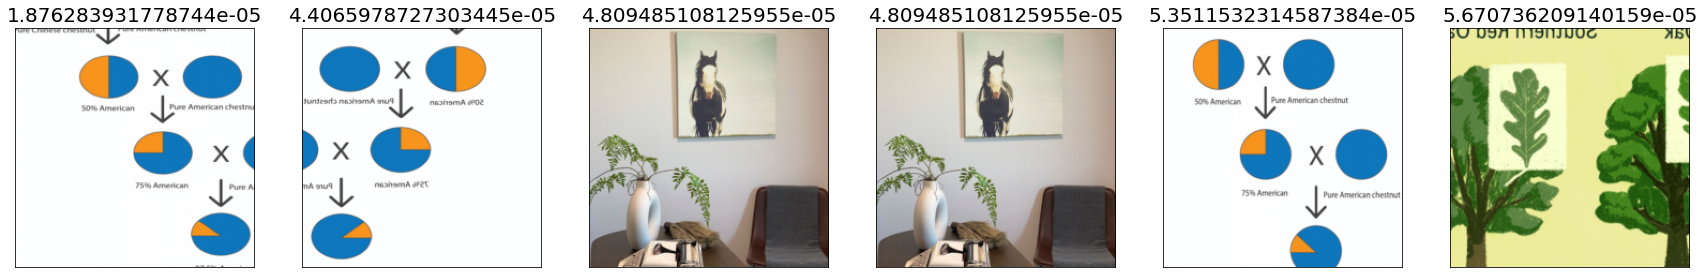

In [ ]:
# examine the 6 worst indices (we'll likely be dropping these)
n = 6
bad_idx = np.argsort(np.array(realtree_likelihood))[:n].tolist()

dset_bad = Subset(treeds, bad_idx)
badloader = DataLoader(dset_bad, batch_size=n, shuffle=False)
X, y = next(iter(badloader))
show_image_batch(X, MEAN, STD, title=np.array(realtree_likelihood)[bad_idx])

# Summarize original, augmented, and subset datasets

In [ ]:
tree_filelist, image_filelist = get_filelist(data_path + 'images_spec')

In [ ]:
# original dataset
tree_summary = dict.fromkeys(tree_filelist.keys(), [0,0,0,0])
for k, i in tree_filelist.items():
    a = np.array(i)
    count_all = len(a)
    count_bing = len(a[np.char.startswith(a, 'bing-')])
    count_arbor = len(a[np.char.startswith(a, 'arborday-')])
    count_harvard = len(a[np.char.startswith(a, 'harvard-')])
    tree_summary[k] = [count_all, count_bing, count_arbor, count_harvard]

In [ ]:
# augmented dataset
tree_summary_aug = tree_summary
for k in tree_summary.keys():
    tree_summary_aug[k] = [d*8 for d in tree_summary[k]]

In [ ]:
# subset dataset
image_filelist_sub = np.array(image_filelist*8)[realtree_idxs]
tree_summary_sub = dict.fromkeys(tree_filelist.keys(), [0,0,0,0])
for k in tree_summary_sub.keys():
    a = image_filelist_sub[np.char.startswith(image_filelist_sub, k)]
    count_all = len(a)
    count_bing = len(a[np.char.startswith(a, f'{k}-bing-')])
    count_arbor = len(a[np.char.startswith(a, f'{k}-arborday-')])
    count_harvard = len(a[np.char.startswith(a, f'{k}-harvard-')])
    tree_summary_sub[k] = [count_all, count_bing, count_arbor, count_harvard]

In [ ]:
# summary
print('original dataset (all, bing, arborday, harvard):')
print(tree_summary)
print('augmented dataset:')
print(tree_summary_aug)
print('filtered dataset:')
print(tree_summary_sub)

original dataset (all, bing, arborday, harvard):
{'honeylocust': [4008, 4008, 0, 0], 'northernredoak': [4632, 4248, 56, 328], 'blackwalnut': [5208, 4504, 32, 672], 'pecan': [4888, 4728, 48, 112], 'loblollypine': [3960, 3904, 56, 0], 'chinesechestnut': [5296, 3736, 24, 1536], 'blacklocust': [4840, 4496, 0, 344]}
augmented dataset:
{'honeylocust': [4008, 4008, 0, 0], 'northernredoak': [4632, 4248, 56, 328], 'blackwalnut': [5208, 4504, 32, 672], 'pecan': [4888, 4728, 48, 112], 'loblollypine': [3960, 3904, 56, 0], 'chinesechestnut': [5296, 3736, 24, 1536], 'blacklocust': [4840, 4496, 0, 344]}
filtered dataset:
{'honeylocust': [2925, 2925, 0, 0], 'northernredoak': [3536, 3237, 42, 257], 'blackwalnut': [3845, 3327, 23, 495], 'pecan': [3875, 3754, 42, 79], 'loblollypine': [3106, 3059, 47, 0], 'chinesechestnut': [4071, 2905, 17, 1149], 'blacklocust': [3588, 3326, 0, 262]}


In [ ]:
# save results to file
if save_files:
  filename = 'dataset_processing_summary.csv'
  dataset_summ = pd.DataFrame({})
  for summ, desc in zip([tree_summary, tree_summary_aug, tree_summary_sub], ['original', 'augmented', 'filtered']):
      d = pd.DataFrame(summ)
      d.loc[:,'step'] = desc
      d.loc[:,'set'] = pd.Series(['all', 'bing', 'arborday', 'harvard'])
      dataset_summ = pd.concat((d, dataset_summ))

  dataset_summ.reset_index()
  dataset_summ.to_csv(results_path + filename, index=False)

In [ ]:
# git saving cell
%cd '/content/drive/My Drive /git/tree-finder'
!git config --global user.email "erich.j.trieschman@gmail.com"
!git config --global user.name "Erich Trieschman"

!git add .
!git commit -m 'transfer learning models'
!git push

/content/drive/My Drive /git/tree-finder
[main ea85ecb] transfer learning models
 16 files changed, 1662 insertions(+), 542 deletions(-)
 create mode 100644 latex/PaperForReview.out
 create mode 100644 latex/PaperForReview.pdf
 create mode 100644 latex/README.md
 delete mode 100644 latex/README.txt
 create mode 100644 latex/RebuttalTemplate.pdf
 delete mode 100644 latex/egpaper_final.pdf
 delete mode 100644 latex/egpaper_final.synctex.gz
 delete mode 100644 latex/egpaper_final.tex
 delete mode 100644 latex/egpaper_for_review.pdf
 create mode 100644 latex/ieee_fullname.bst
 rewrite notebooks/preprocess_images.ipynb (75%)
 rewrite notebooks/train_binary_tree_classifier.ipynb (89%)
Counting objects: 16, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (16/16), done.
Writing objects: 100% (16/16), 2.40 MiB | 5.75 MiB/s, done.
Total 16 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/etrieschman

In [ ]:
%cd '/content/drive/My Drive /git/tree-finder'
!git config --global user.email "erich.j.trieschman@gmail.com"
!git config --global user.name "Erich Trieschman"
!git status

/content/drive/My Drive /git/tree-finder
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   .gitignore
	modified:   notebooks/preprocess_images.ipynb
	modified:   notebooks/scrape_trees.ipynb
	modified:   notebooks/train_binary_tree_classifier.ipynb
	modified:   notebooks/train_species_classifiers.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	data/
	models/ConvNextClassifierFC.pt
	models/ResnetClassifierFC.pt
	models/TransformerClassifierFC.pt

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add .

In [ ]:
! git commit -m 'MESSAGE'
! git push